## 1. Introduction

### Things we are going to do:
* Write the seperate code for Training, Validating and Testing the Network
* Use Transfer Learning
* Use Albumentations for Transforms
* Use a custom dataset to load data


## 2. Import libraries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader


import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm

### 3. Define Params

In [44]:
####################################################
#                Define parameters
####################################################

params = {
#    "model": "resnet50",
    #"device": "cuda",
    "lr": 0.001,
    "batch_size": 64,
    "num_workers": 20,
    "n_epochs": 100,
    "image_size": 256, 
    "in_channels": 3, 
    "num_classes": 50
}



### 4. Define Transform

In [3]:
#######################################################
#               Define Transforms
#######################################################

train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=params["image_size"], width=params["image_size"]),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=params["image_size"], width=params["image_size"]),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

### 5. Load Dataset

In [4]:
train_data_path = 'images/train'
test_data_path = 'images/test'

In [6]:
####################################################
#       Create Train, Valid and Test sets
####################################################
train_data_path = 'images/train'
test_data_path = 'images/test'

train_image_paths = []
classes = []

for data_path in glob.glob(train_data_path + '/*')[:params['num_classes']]:
    classes.append(data_path.split('/')[-1])
    train_image_paths.append(glob.glob(data_path + '/*'))
    

train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)
#split train valid from train paths (80,20)
train_image_paths, valid_image_paths = train_image_paths[:int(0.9*len(train_image_paths))], train_image_paths[int(0.9*len(train_image_paths)):] 


test_image_paths = []
for data_path in glob.glob(test_data_path + '/*')[:params['num_classes']]:
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

Train size: 4496
Valid size: 500
Test size: 1250


In [7]:
#######################################################
#      Create dictionary for class indexes
#######################################################

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}


In [8]:
idx_to_class

{0: '40.Stockholm_City_Hall',
 1: '04.Wroclaws_Dwarves',
 2: '24.Soreq_Cave',
 3: '47.Prague_Astronomical_Clock',
 4: '06.Niagara_Falls',
 5: '27.Seattle_Japanese_Garden',
 6: '35.Monumento_a_la_Revolucion',
 7: '19.Vienna_City_Hall',
 8: '26.Pont_du_Gard',
 9: '21.Taj_Mahal',
 10: '01.Mount_Rainier_National_Park',
 11: '20.Matterhorn',
 12: '12.Kantanagar_Temple',
 13: '46.Great_Wall_of_China',
 14: '36.Badlands_National_Park',
 15: '07.Stonehenge',
 16: '31.Washington_Monument',
 17: '42.Death_Valley_National_Park',
 18: '15.Central_Park',
 19: '09.Golden_Gate_Bridge',
 20: '43.Gullfoss_Falls',
 21: '13.Yellowstone_National_Park',
 22: '32.Hanging_Temple',
 23: '41.Machu_Picchu',
 24: '02.Ljubljana_Castle',
 25: '14.Terminal_Tower',
 26: '39.Gateway_of_India',
 27: '03.Dead_Sea',
 28: '08.Grand_Canyon',
 29: '17.Changdeokgung',
 30: '05.London_Olympic_Stadium',
 31: '10.Edinburgh_Castle',
 32: '25.Banff_National_Park',
 33: '45.Temple_of_Heaven',
 34: '49.Temple_of_Olympian_Zeus',
 3

In [9]:
print('Length of train: ', len(train_image_paths))
print('Length of test: ', len(test_image_paths))

Length of train:  4496
Length of test:  1250


In [10]:
#######################################################
#               Define Dataset Class
#######################################################

class LandmarkDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label

In [11]:
#######################################################
#                  Create Dataset
#######################################################

train_dataset = LandmarkDataset(train_image_paths,train_transforms)
valid_dataset = LandmarkDataset(valid_image_paths,test_transforms) #test transforms are applied
test_dataset = LandmarkDataset(test_image_paths,test_transforms)

#######################################################
#                  Define Dataloaders
#######################################################

train_loader = DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers = params['num_workers'], pin_memory = True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=params["batch_size"], shuffle=True, num_workers = params['num_workers'], pin_memory = True
)


test_loader = DataLoader(
    test_dataset, batch_size=params["batch_size"], shuffle=False, num_workers = params['num_workers'], pin_memory = True
)

loaders = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}




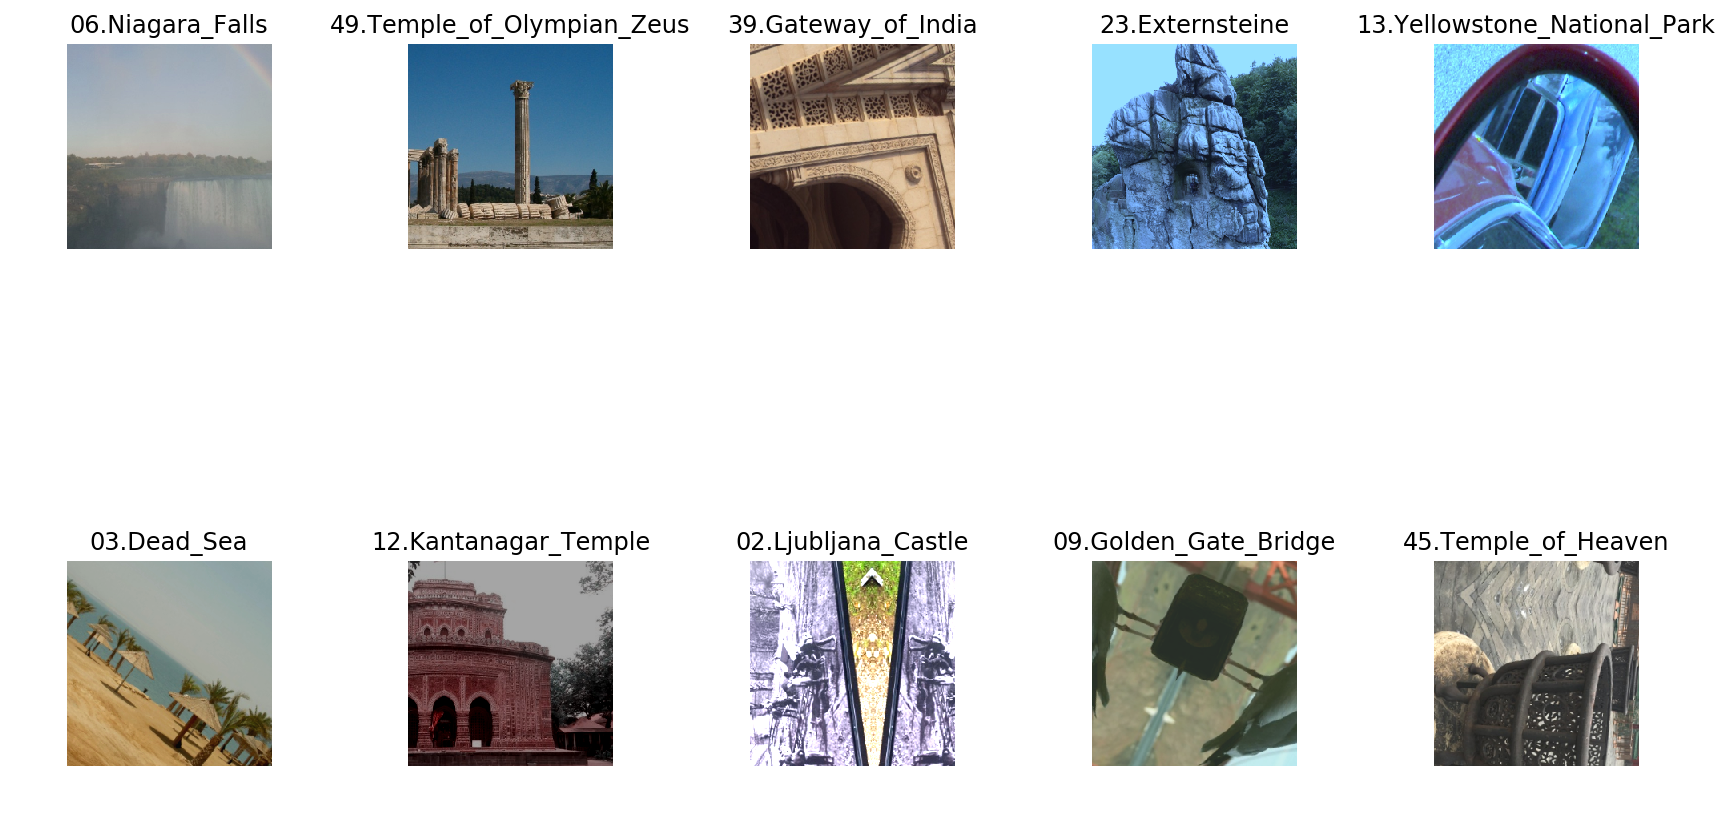

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline


#######################################################
#                  Visualize Dataset
#         Images are plotted after augmentation
#######################################################

def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)

In [13]:
# useful variable that tells us whether we should use the GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 6. Train

In [14]:
num_classes = len(classes)
num_classes

50

In [52]:
model = models.resnet50(pretrained=True)

In [53]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [54]:
def Net(num_classes):
    model = models.resnet50(pretrained=True)
    #model = EfficientNet.from_pretrained('efficientnet-b0')
    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False

    from collections import OrderedDict
    classifier = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(2048, 1024)),
                              ('relu', nn.ReLU()),
                              ('fc2', nn.Linear(1024, 256)),
                              ('relu', nn.ReLU()),
                              ('fc3', nn.Linear(256, num_classes)),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))

    model.fc = classifier
    return model

model = Net(params['num_classes'])
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [55]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader):
    #put model in training state
    model.train()
    
    train_loss = 0.0
    
    #pbar = tqdm(enumerate(train_loader), total = len(train_loader))
    #for step, (imgs, labels) in pbar:
    
    for batch_idx, (imgs, labels) in enumerate(train_loader):  
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs)
        loss = loss_fn(preds, labels)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
    
        train_loss+= ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
        #if batch_idx%5==0:
        #    print('train loss', train_loss)
    
    print('Epoch {} avg Training loss: {:.3f}'.format(epoch+1, train_loss))
    
    return model, train_loss
        
def test_one_epoch(epoch, model, loss_fn, loader, img_paths):
    model.eval()
    
    #pbar = tqdm(enumerate(test_loader), total = len(test_loader))
    running_loss = 0
    actual_labels = []
    pred_labels = []
    
    #for step, (imgs, labels) in pbar:
    for batch_idx, (imgs, labels) in enumerate(loader):    
        imgs, labels = imgs.to(device), labels.to(device)
        log_preds = model(imgs)
        loss = loss_fn(log_preds, labels)
        
        
        preds = torch.exp(log_preds)
        running_loss+=((1 / (batch_idx + 1)) * (loss.data.item() - running_loss))
        
        #calculate accuracy
        top_prob, top_class = preds.topk(1, dim=1)
        pred_labels+= list((top_class.view(-1)).cpu().numpy())
        actual_labels+= list(labels.cpu().numpy())
        
        
    
    accuracy = ((np.array(pred_labels)==np.array(actual_labels)).sum())/len(img_paths) #size of test set
    correct = ((np.array(pred_labels)==np.array(actual_labels)).sum())
    total = len(img_paths)
    
    
    return running_loss, accuracy, correct, total



In [56]:
loss_fn = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = params['lr'])

In [57]:
train_losses = []
valid_losses = []
for epoch in range(params['n_epochs']):
    train_loss = train_one_epoch(epoch, model, loss_fn, optimizer, train_loader)
    train_losses+= [train_loss]
    
    
    valid_loss, accuracy, correct, total = test_one_epoch(epoch, model, loss_fn, valid_loader, valid_image_paths)
    valid_losses+=[valid_loss]
    print('Epoch {} avg Valid loss: {:.3f}'.format(epoch+1, valid_loss))
    print('Epoch {} Valid accuracy: {:.1%} ({} of {} right)\n'.format(epoch+1, accuracy, correct, total))
    
    if len(valid_losses)>1 and (valid_loss<min(valid_losses[:-1])):
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn,
            'train_transforms': train_transforms,
            'test_transforms': test_transforms,
            }, 'checkpoint.tar')

Epoch 1 avg Training loss: 3.438
Epoch 1 avg Valid loss: 2.710
Epoch 1 Valid accuracy: 29.0% (145 of 500 right)

Epoch 2 avg Training loss: 2.655
Epoch 2 avg Valid loss: 1.953
Epoch 2 Valid accuracy: 48.2% (241 of 500 right)

Epoch 3 avg Training loss: 2.373
Epoch 3 avg Valid loss: 1.761
Epoch 3 Valid accuracy: 54.8% (274 of 500 right)

Epoch 4 avg Training loss: 2.278
Epoch 4 avg Valid loss: 1.626
Epoch 4 Valid accuracy: 56.4% (282 of 500 right)

Epoch 5 avg Training loss: 2.139
Epoch 5 avg Valid loss: 1.509
Epoch 5 Valid accuracy: 57.8% (289 of 500 right)

Epoch 6 avg Training loss: 2.109
Epoch 6 avg Valid loss: 1.406
Epoch 6 Valid accuracy: 61.0% (305 of 500 right)

Epoch 7 avg Training loss: 2.049
Epoch 7 avg Valid loss: 1.502
Epoch 7 Valid accuracy: 60.0% (300 of 500 right)

Epoch 8 avg Training loss: 1.978
Epoch 8 avg Valid loss: 1.365
Epoch 8 Valid accuracy: 62.4% (312 of 500 right)

Epoch 9 avg Training loss: 1.947
Epoch 9 avg Valid loss: 1.390
Epoch 9 Valid accuracy: 60.6% (30

Epoch 72 avg Training loss: 1.462
Epoch 72 avg Valid loss: 1.064
Epoch 72 Valid accuracy: 72.8% (364 of 500 right)

Epoch 73 avg Training loss: 1.399
Epoch 73 avg Valid loss: 1.132
Epoch 73 Valid accuracy: 71.2% (356 of 500 right)

Epoch 74 avg Training loss: 1.447
Epoch 74 avg Valid loss: 1.197
Epoch 74 Valid accuracy: 71.2% (356 of 500 right)

Epoch 75 avg Training loss: 1.403
Epoch 75 avg Valid loss: 1.093
Epoch 75 Valid accuracy: 72.8% (364 of 500 right)

Epoch 76 avg Training loss: 1.428
Epoch 76 avg Valid loss: 1.054
Epoch 76 Valid accuracy: 72.0% (360 of 500 right)

Epoch 77 avg Training loss: 1.411
Epoch 77 avg Valid loss: 1.046
Epoch 77 Valid accuracy: 74.8% (374 of 500 right)

Epoch 78 avg Training loss: 1.400
Epoch 78 avg Valid loss: 1.102
Epoch 78 Valid accuracy: 71.4% (357 of 500 right)

Epoch 79 avg Training loss: 1.409
Epoch 79 avg Valid loss: 1.099
Epoch 79 Valid accuracy: 74.4% (372 of 500 right)

Epoch 80 avg Training loss: 1.409
Epoch 80 avg Valid loss: 1.073
Epoch 8

### Testing the model

In [58]:
# load the model that got the best validation accuracy
checkpoint = torch.load('checkpoint.tar')
loaded_model = Net(params['num_classes'])
loaded_model.to(device)
loaded_model.load_state_dict(checkpoint['model_state_dict'])

loaded_criterion = checkpoint['loss']

#optimizer = optim.Adam(model.parameters(), lr = 0.003)
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

last_epoch = checkpoint['epoch']+1

test_loss, accuracy, correct, total = test_one_epoch(None, loaded_model, loaded_criterion, test_loader, test_image_paths)

print('Test loss: {:.3f}'.format(test_loss))
print('Test accuracy: {:.1%} ({} of {} right)\n'.format(accuracy, correct, total))
    

Test loss: 0.955
Test accuracy: 75.4% (943 of 1250 right)

